In [1]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load weight

In [3]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

=> Loading checkpoint


In [27]:
def generate_examples(gen, steps, root_path, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)),
                                 device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img * 0.5 + 0.5, f"../{root_path}/saved_examples/img_{i}.png")
    gen.train()

In [29]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCiFAR//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [30]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

In [7]:
steps = [0,1,2,3,4]
alpha = 1

In [8]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [9]:
# Load CIFAR (real data)    
real_loader, datasets = get_loader_CIFAR(4 * 2 ** steps[3])
real_C, labels = next(iter(real_loader))

Files already downloaded and verified


In [10]:
# Load CelebA (real data)    
real_loader, datasets = get_loader(4 * 2 ** steps[3], r"../../Celeba_dataset/img_align_celeba")
real_Ce, labels = next(iter(real_loader))

In [32]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader))

In [33]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader))

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


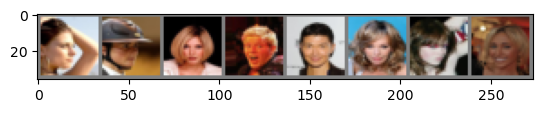

In [19]:
imshow(torchvision.utils.make_grid(real_Ce[:8]))

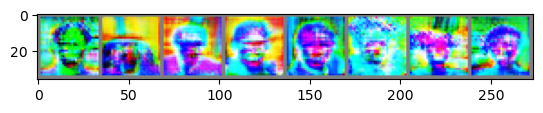

In [21]:
fixed_fakes = gen(config.FIXED_NOISE, alpha, steps[3])
imshow(torchvision.utils.make_grid(fixed_fakes[:8]))

In [24]:
print("Calculating Inception Score...")
print(inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits=10))
means_Ce, std_Ce = inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits=10)

Calculating Inception Score...


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\quock\AppData\Local\Temp\ipykernel_18336\3713301467.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(1.0, 0.0)


In [26]:
means_fake, std_fake = inception_score(fake, cuda=False, batch_size=10, resize=True, splits=10)
print(means_fake, std_fake)

c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\quock\AppData\Local\Temp\ipykernel_18336\3713301467.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


1.0 0.0
